## Embeddings extraction
On this notebook I will compare a target image to a pool of other images, this simulates the process where a customer uploads his picture that will be compared to store images.  

The strategy will be to use a neural network already trained on the imagenet dataset and use it to extract the embeddings of all the store images. These embeddings will be saved and when a new image is uploaded to the server the embedding of that image will be extracted and compared to the other ones where the "n" most similar images will be returned. To compare the images cosine similarity will be used.

For efficiency purposes embeddings are run only once and exported to a csv file, then the file is loaded into memory.

## To do

- Clean up dataset
- Clean up code
- Restructure notebooks

In [1]:
import os
import sys
import re
import shutil
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tqdm import tqdm
from tqdm import tqdm_notebook 
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning

#loadded three different models to test which one perfomrs better
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import preprocess_input as prep_input_RN50
from keras.applications.vgg16 import preprocess_input as prep_input_VGG16
from keras.applications.mobilenet import preprocess_input as prep_input_MN
from keras.preprocessing import image
#pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


## Selecting the products from the store

For simplicity we will select dresses and tops.  

We are applying a KNeighbors Search algorithm to retrieve similar images, in order to obtain a fair evaluation of the algorithm we will use a similar amount of products and categories that the amount a usual store would have in stock. Given this amount of products per category we want to establish a a series of benchmarks to evaluate the performance of the algorithm **EXPLAIN A BIT MORE ABOUT THE DATASET PAIR MATCHES ETC**  

This means sampling down the amount of products (unique id & unique photo).

### For simplicity filtering out images that have duplicated categories & duplicated bboxes
Duplicated categories are usually troublesome since it means the same photo has been reused for different products and therefore the quality of each of the product is deemed to be poorer than the usual image a customer would upload. A customer is expected to upload a photo with reasonable quality in terms of lighting, perspective and size.

Some of the photos have duplicated bounding boxes, this is due to the same items appearing more than once in the photo or due to other unknown reasons, to make it simple we will filter these photos out too.

In [2]:
customer_df = pd.read_csv("../../customer_df.csv")
retrieval_df = pd.read_csv("../../retrieval_df.csv")

In [3]:
#filtering by unique photos
freq_categories = pd.DataFrame(customer_df["photo"].value_counts())
freq_categories = freq_categories[freq_categories["photo"] == 1]
customer_df = customer_df[customer_df["photo"].isin(freq_categories.index)]

print(customer_df.shape)
print(customer_df["category"].value_counts())

(9034, 8)
dresses      5996
tops         1164
footwear      568
outerwear     498
leggings      240
skirts        211
bags          132
eyewear       126
pants          46
belts          43
hats           10
Name: category, dtype: int64


### Joining customer and retrieval & filtering categories
This will discard all images that do not match to customer_df. These are images introduced by the original dataset as extra noise.

Will filter categories to dresses and tops. These categories are selected due to the volume of available images and due to having less noise than other categories.

In [4]:
#merging both datasets to get rid of the retrieval products that do not match
matches_df = customer_df.merge(retrieval_df, how="inner", on="id", suffixes=("_cust", "_retr"))
matches_df = matches_df[matches_df["category_cust"].isin(["dresses", "tops"])]
matches_df.head(3)

photo_cust  product_cust category_cust             id  height   left  \
127       16319         54349       dresses  54349_dresses  1431.0  182.0   
128       16319         54349       dresses  54349_dresses  1431.0  182.0   
129       16319         54349       dresses  54349_dresses  1431.0  182.0   

       top   width  photo_retr  product_retr category_retr  
127  480.0  1419.0       37491         54349       dresses  
128  480.0  1419.0       37492         54349       dresses  
129  480.0  1419.0       37493         54349       dresses

### Building final dataframes for customer & retrieval and list of paths to these photos

In [5]:
np.random.seed(2018) #select how many photos in each set, randomly shuffled
#matched items
perm = np.random.permutation(matches_df['product_cust'].unique()) #permutes list of photos randomly
split = int(len(matches_df['product_cust'].unique())*0.5)
valid, test = np.split(perm, [split])
valid_df = matches_df[matches_df['product_cust'].isin(valid)]
test_df = matches_df[matches_df['product_cust'].isin(test)]

In [6]:
print("Dresses_val:", len(valid_df[valid_df['category_cust'] == 'dresses']))
print("Tops_val:   ", len(valid_df[valid_df['category_cust'] == 'tops']))

Dresses_val: 12484
Tops_val:    2116


In [7]:
print("Dresses_test:", len(test_df[test_df['category_cust'] == 'dresses']))
print("Tops_test:   ", len(test_df[test_df['category_cust'] == 'tops']))

Dresses_test: 12838
Tops_test:    2197


In [8]:
# sampling = 2000
# all_df = []
# for df in [valid_df, test_df]:
#     all_df.append(df.sample(sampling, random_state=2018)) #in case we want to further reduce the sets we take a sample)
# valid_df, test_df = all_df[0], all_df[1]

### Copying photos to new directories

In [65]:
dataset_path = "../photos_resized"

for step in zip([valid_df , test_df], ["validation", "test"]):
    photos_list_cust = step[0]["photo_cust"].unique().tolist()
    photos_list_cust = [str(photo) + ".jpg" for photo in photos_list_cust]

    photos_list_retr = step[0]["photo_retr"].unique().tolist()
    photos_list_retr = [str(photo) + ".jpg" for photo in photos_list_retr]

    output_path = os.path.join("..", "photos_classified", step[1])
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)
        os.makedirs(os.path.join(output_path, "customer"))
        os.makedirs(os.path.join(output_path, "retrieval"))

    print("Creating customer " + step[1] + " images")
    for photo in tqdm(photos_list_cust):
        shutil.copy(os.path.join(dataset_path, photo), os.path.join(output_path, "customer", photo))

    print("Creating retrieval " + step[1] + " images")
    for photo in tqdm(photos_list_retr):
        shutil.copy(os.path.join(dataset_path, photo), os.path.join(output_path, "retrieval", photo))

In [9]:
valid_df_cust = customer_df[customer_df['photo'].isin(valid_df["photo_cust"].unique())]
valid_df_retr = retrieval_df[retrieval_df['photo'].isin(valid_df["photo_retr"].unique())]

test_df_cust = customer_df[customer_df['photo'].isin(test_df["photo_cust"].unique())]
test_df_retr = retrieval_df[retrieval_df['photo'].isin(test_df["photo_retr"].unique())]

In [10]:
#CRITICAL SO IMAGES ARE IN SAME ORDER AS EMBEDDINGS FILE
valid_df_retr = valid_df_retr.sort_values(by="photo")
test_df_retr = test_df_retr.sort_values(by="photo")

In [11]:
#this is how many distint products we have in reality, the more photos we have of each the better though
print("Number of photos/embeddings in store", valid_df_retr["photo"].unique().shape[0])
print(valid_df_retr.drop_duplicates(subset=["id"])["category"].value_counts())
print("Number of matches: ", valid_df.shape[0])

Number of photos/embeddings in store 7344
dresses    1397
tops        395
Name: category, dtype: int64
Number of matches:  14600


In [12]:
#this is how many distint products we have in reality, the more photos we have of each the better though
print("Number of photos/embeddings in store", test_df_retr["photo"].unique().shape[0])
print(test_df_retr.drop_duplicates(subset=["id"])["category"].value_counts())
print("Number of matches: ", test_df.shape[0])

Number of photos/embeddings in store 7429
dresses    1387
tops        410
Name: category, dtype: int64
Number of matches:  15035


As seen above, in validation we have:
- 1397 dresses and 395 tops, these are unique products, however there usually are more than 1 photo per product.
- 14600 total photos, the number of vectors in the database will be equal.
- 14600 matches, since we can have a customer photo matching more than one retrieval photo and we can also have different photos in customer from the same product.

### Loading  images

In [55]:
def read_image(img_path):
    """ Reads images from a path into an array.
    Fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
    Fixes exception with CMYK images having 4 colour channels ie. 4622.jpg from street2shop """
    
    img_array = mpimg.imread(img_path)
    if (len(img_array.shape) == 2) or (img_array.shape[2] > 3):
            img_array = np.array(Image.fromarray(img_array).convert("RGB"))
    return img_array

def bbox_corners(img_path, df): #NEED TO CHANGE THE CUSTOMER DF; COLUMN LEFT IS ACTUALLY THE TOP COORDENATES
    """ Reads an img path, captures the photo ID (HAS TO BE UNIQUE IN THE DF) and returns the
    bounding box corners """
    
    img_id = re.split("(\\d+)", img_path)[-2]
    img_df = df[df["photo"] == int(img_id)] #assumes there are unique photo names in the df.photo
    top, left, width, height = (int(img_df["left"]), int(img_df["top"]), int(img_df["width"]), int(img_df["height"]))
    return top, left, width, height

def show_image(img_array, img_path=None, customer_df=None, title="Image", bbox=False):
    fig,ax = plt.subplots(1, figsize=(5,5))
    ax.imshow(img_array)
    plt.title(title)
    plt.axis("off")
    
    if bbox == True:
        left, top, width, height = bbox_corners(img_path, customer_df)
        rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()
                        
def crop_image(img_path, customer_df, resize):
    top, left, width, height = bbox_corners(img_path, customer_df)
    img_array = read_image(img_path)
    image_cropped = img_array[left:left+height , top:top+width, :]    
    image_cropped = cv2.resize(image_cropped, dsize=resize, interpolation=cv2.INTER_CUBIC)
    return image_cropped

def show_recommend(top_n, dataset_path, img_path, customer_df, retrieval_ranked, resize, bbox=True):
    img_array = read_image(target_img)
    show_image(img_array, img_path, customer_df, title = "User image", bbox=bbox)
    if bbox==True:
        cropped = crop_image(img_path, customer_df, resize=resize)
        show_image(cropped, title="Cropped image")
    
    img_paths = retrieval_ranked['photo'][:top_n]
    print("Top {} similar images".format(top_n))
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(img_paths))
    for n, i in enumerate(img_paths):
        ax = fig.add_subplot(gs[0, n])
        recomend_path = os.path.join(dataset_path, str(i)+".jpg")
        ax.imshow(mpimg.imread(recomend_path))
        ax.axis("off")
    plt.show()

In [42]:
def find_paths(dataset_path):
    img_paths = os.listdir(dataset_path)
    img_paths = sorted(img_paths, key = lambda x: int(re.sub("(\\D)", "", x))) #sorts numerically rather than alphabetically
    img_paths = [os.path.join(dataset_path, img) for img in img_paths]
    return img_paths

def save_embeddings(dataset_path, file_name, shape, resize):
    imgs = find_paths(dataset_path)
    embeddings_np = np.zeros((len(imgs), shape)) #use 1024 for MobileNet and 512 for VGG16
    
    for n, img in enumerate(tqdm(imgs)):
        img_array = read_image(img)
        img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
        img_array = preprocess_input(img_array)
        img_array = model.predict(np.expand_dims(img_array, axis=0)) #default ouput shape (6,6,2048)
        embeddings_np[n] = img_array#.flatten() #TESTING WITHOUT FLATTEN
    embeddings_np = embeddings_np.astype(np.float16)
    
    np.save(file_name, embeddings_np) #npy files save/load faster than csv when working with ndarrays
    
def rank_recommendations(img_path, customer_df, embs_retrieval, resize, bbox=True, method="cosine"):
    if bbox == True:
        img_array = crop_image(img_path, customer_df, resize=resize) #crops to bbox and resizes
    else:
        img_array = read_image(img_path)
        img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
    proc_img = preprocess_input(np.expand_dims(img_array, axis=0)) #preprocess to NN format
    embs_target = model.predict(proc_img) #extracts embedding

    distance = cdist(embs_retrieval, embs_target.reshape(1,-1), method) #distances from user photo to retrieval
    rank = np.argsort(distance.ravel()) #ranks by similarity, returns the indices that would sort the distance array
    return rank

def rank_similar(target_img, customer_df, retrieval_df, rank):
    """
    Finds the image id in the customer_df.
    Ranks all images by similarity keeping only highest match for each product.    
    """
    img_name = re.split("(\\d+)", target_img)[-2]
    target_df = customer_df[customer_df["photo"] == int(img_name)] #finds image name
    target_id = target_df["id"].unique().tolist()[0] #finds its image id
    
    retrieval_ranked = retrieval_df.iloc[rank] #reindex based on distances
    retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account
    retrieval_ranked = retrieval_ranked.reset_index(drop=True) #resets index
    same_image_rank = retrieval_ranked[retrieval_ranked["id"] == target_id].index.values.tolist() #extracts index positions
    return same_image_rank, retrieval_ranked

## Creating embeddings

- We will start by chosing an already trained neural network and removing the bottom layers since our intention is to use it for feature extraction and not for classification.
- Then we will extract features for each of the images from the specified retrieval directory and save it on disk to save us from doing this process every time.
- Once this file is created we load it up so we can start comparing new images to the retrieval images.

In [47]:
dataset_path = os.path.join("..", "..", "photos_classified")
retrieval_val_path = os.path.join(dataset_path, "validation", "retrieval")

resizing = (250,250)
shape_output = 2048
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
preprocess_input = prep_input_RN50

# include_top=False removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.
# pooling='avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.

In [48]:
# For testing with MobileNet:
resizing = (224,224)
shape_output = 1024
model = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
preprocess_input = prep_input_MN

In [67]:
%%time
#ONLY RUN THE FIRST TIME FOR EACH MODEL TO SAVE ALL EMBEDDINGS TO DISK
save_embeddings(retrieval_val_path, "embeddings_val.npy", model, shape_output, resize=resizing)

In [44]:
embs_retrieval = np.load("../../embeddings_val.npy")

## Visual evaluation

In [45]:
valid_df_cust.sample(10)["photo"] #sample picks for visual evaluation

16234     3685
15718    15822
8284     11023
11501     2712
17448     6217
12787     3130
332       3266
16546    17355
1927      8805
11627     4436
Name: photo, dtype: int64

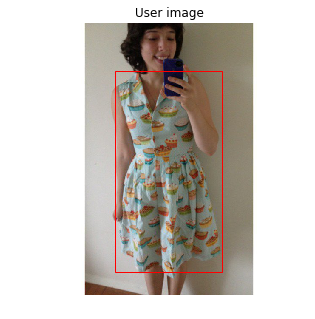

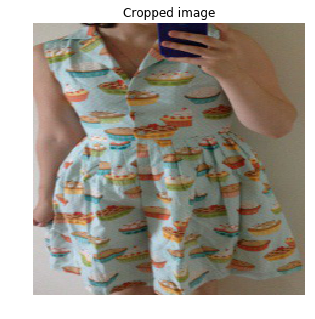

Top 10 similar images


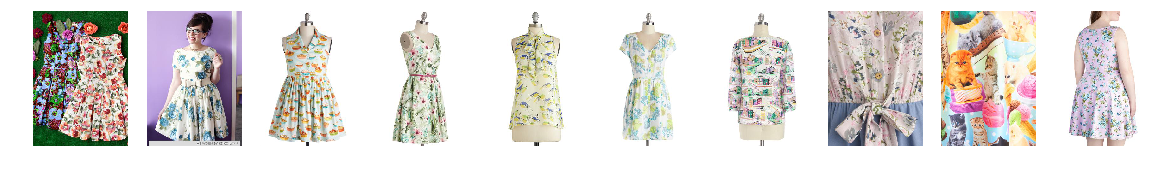

Same images ranked on indices: [2]
Wall time: 1.02 s


In [50]:
%%time
target_img = "../../photos_classified/validation/customer/12376.jpg" #6324.jpg #CHECK PHOTO 13279.jpg TO FIX
rank = rank_recommendations(target_img, valid_df_cust, embs_retrieval, model, resize=resizing)

top_n = 10
same_image_rank, retrieval_ranked = rank_similar(target_img, valid_df_cust, valid_df_retr, rank)
show_recommend(top_n, retrieval_val_path, target_img, valid_df_cust, retrieval_ranked, resize=resizing)
print("Same images ranked on indices: {}".format(same_image_rank))

## Measuring model performance

Once we have created an embeddings file from which the most "n" similiar images are returned we need to measure how this process is performing.  
This score will allow us to make improvements in order to find the best parameters and methods.

For the evaluation we will only use customer photos, and each one of them will be compared with the retrieved photos. As a result obtain a rank starting from the most similar photo. Then we will define a K parámeter that will set the top k images from the returned rank.

To **evaluate** the model the the following method will be used:
   - Accuracy@K: total number of positive cases / total number of cases
   
To **improve** the model accuracy the following hyperparameters will be fine-tuned:
   - Distance methods: euclidean, cosine, chebyshev
   - Pre-Trained models: VGG16, ResNet50, MobileNet

In [56]:
def evaluate(customer_df, retrieval_df, embs_retrieval, k_list, val_test, model, resize=resizing, method="cosine"):
    
    #assumes customer_df already includes all images we will use
    customer_paths = [os.path.join("..", "..", "photos_classified", val_test, "customer", str(img) + ".jpg")
                      for img in customer_df["photo"].tolist()]
    
    positives = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 }
    accuracy_all = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 }
    with tqdm_notebook(total=len(customer_paths)) as pbar:    
        for n, customer_path in enumerate(customer_paths):
            photo_name = re.split("(\\d+)", customer_path)[-2] #finding photo name
            image_customer = customer_df[customer_df["photo"] == int(photo_name)] #finding photo id
            image_id = image_customer['id'].tolist()[0] #always same id even if more than >1 rows
            image_category = image_customer["category"].tolist()[0] #finding photo category

            rank = rank_recommendations(customer_path, customer_df, embs_retrieval, model, resize=resize, method=method)
            
            for i, k in enumerate(k_list):
                retrieval_ranked = retrieval_df.iloc[rank[:k]] #retrieval ranked
                retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account, EXPLAIN BETTER IN MARKDOWN
                retrieval_ranked_list = retrieval_ranked["id"].tolist()

                if image_id in retrieval_ranked_list:
                    positives[image_category][i] += 1
            pbar.update(1)
        
        for i, k in enumerate(k_list): #iterates over levels of k
            print("****************** Accuracy at {} ******************".format(k))
            for cat in positives.keys(): #iterates over categories
                total_cat = customer_df[customer_df["category"] == cat].shape[0]
                
                accuracy = positives[cat][i] / total_cat
                accuracy_all[cat][i] = accuracy*100
                print("{}: {:.3f}%".format(cat, accuracy*100))
    return accuracy_all

### Fine-tuning: Distances

In [66]:
%%time
distances = ["euclidean", "cosine", "chebyshev"]
k = [5,10,20,30,40,50]
acc_distances = {}

for distance in distances:
    print("Calculating {} distance\n".format(distance))
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, val_test="validation", model,
                   resize=resizing, method=distance)
    acc_distances[distance] = acc

In [ ]:
joblib.dump(acc_distances, "acc_distances.pkl")

In [59]:
acc_distances = joblib.load("acc_distances.pkl")

In [60]:
col_names = ["acc@5", "acc@10", "acc@20", "acc@30", "acc@40", "acc@50"]

df_dresses = pd.DataFrame(acc_distances).T["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names)

df_tops = pd.DataFrame(acc_distances).T["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_dresses.index, columns=col_names)

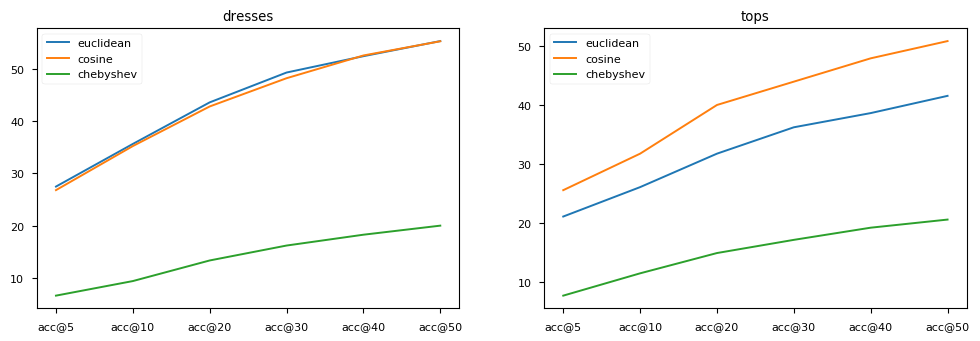

In [82]:
fig = plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_dresses.T["euclidean"])
plt.plot(col_names, df_dresses.T["cosine"])
plt.plot(col_names, df_dresses.T["chebyshev"])
plt.legend()
plt.title("dresses")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_tops.T["euclidean"])
plt.plot(col_names, df_tops.T["cosine"])
plt.plot(col_names, df_tops.T["chebyshev"])
plt.legend()
plt.title("tops")
plt.show()

### Fine-tuning: models

In [18]:
nn_VGG16 = VGG16(weights="imagenet", include_top=False, pooling="avg")
nn_Mobile = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
nn_ResNet50 = ResNet50(weights="imagenet", include_top=False, pooling="avg")

In [ ]:
%%time
k = [5,10,20,30,40,50]
distance = "cosine"
models = [nn_VGG16, nn_ResNet50, nn_Mobile]
prep_inputs = [prep_input_VGG16, prep_input_RN50, prep_input_MN]
shapes = [512, 2048, 1024]
resizings = [(250,250), (250,250), (224,224)]

acc_models = {}

for n in zip(models, prep_inputs, shapes, resizings):
    model, preprocess_input, shape, resizing = n[0], n[1], n[2], n[3]
    print("Calculating {}\n".format(model.name))
    save_embeddings(os.path.join(dataset_path, "validation", "retrieval"), resize=resizing, shape=shape)
    embs_retrieval = np.load("./embeddings.npy")
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, val_test="validation", model,
                   resize=resizing, method=distance)
    acc_models[model.name] = acc

In [ ]:
joblib.dump(acc_models, "acc_models.pkl")

In [83]:
acc_models = joblib.load("acc_models.pkl")

In [86]:
df_dresses = pd.DataFrame(acc_models).T["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names)

df_tops = pd.DataFrame(acc_models).T["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_dresses.index, columns=col_names)

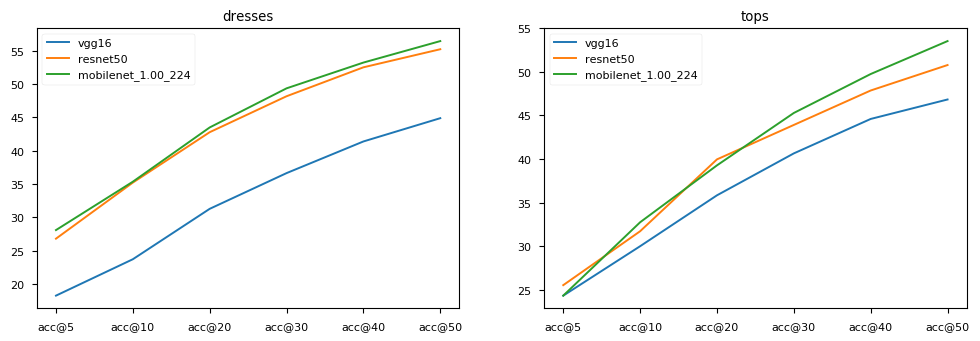

In [88]:
fig = plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_dresses.T["vgg16"])
plt.plot(col_names, df_dresses.T["resnet50"])
plt.plot(col_names, df_dresses.T["mobilenet_1.00_224"])
plt.legend()
plt.title("dresses")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_tops.T["vgg16"])
plt.plot(col_names, df_tops.T["resnet50"])
plt.plot(col_names, df_tops.T["mobilenet_1.00_224"])
plt.legend()
plt.title("tops")
plt.show()

Based on these results we will select the **"cosine"** method to calculate distances and the **MobileNet** model for the rest of our project.

![formula_cosine](http://cs.carleton.edu/cs_comps/0910/netflixprize/final_results/knn/img/knn/cos.png?width=500)

![idea for network](https://cdn-images-1.medium.com/max/1600/1*ZA6O4-IZwvSmaj5Ddh_ZnA.png)

In [ ]:
k = [5,10,20,30,40,50]
distance = "cosine"
model = nn_Mobile
preprocess_input = prep_input_MN
shape = 1024
resizing = (224,224)

## Final validation & Test

In [ ]:
#Validation
save_embeddings(os.path.join(dataset_path, "validation", "retrieval"),
                file_name="embeddings_val.npy", resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings.npy")
acc_valid = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, val_test="validation", model,
                     resize=resizing, method=distance)
joblib.dump(acc_valid, "acc_valid.pkl")
# acc_valid = joblib.load("acc_valid.pkl")

In [ ]:
#Test
save_embeddings(os.path.join(dataset_path, "test", "retrieval"),
                file_name="embeddings_test.npy", resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings_test.npy")
acc_test = evaluate(test_df_cust, test_df_retr, embs_retrieval, k, val_test="test", model,
                    resize=resizing, method=distance)
joblib.dump(acc_test, "acc_test.pkl")
# acc_test = joblib.load("acc_test.pkl")

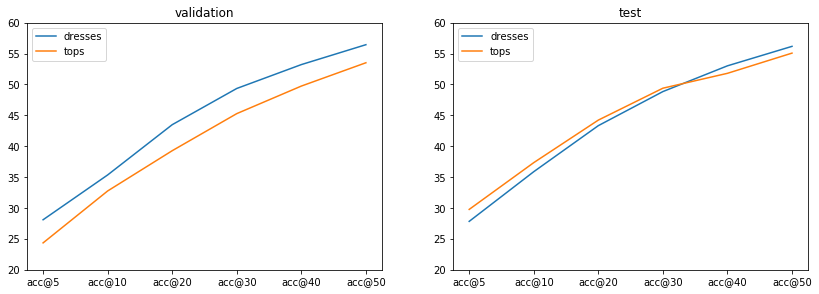

In [73]:
df_valid = pd.DataFrame(acc_valid, index=col_names)
df_test = pd.DataFrame(acc_test, index=col_names)

fig = plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_valid["dresses"])
plt.plot(col_names, df_valid["tops"])
plt.ylim((20,60))
plt.legend()
plt.title("validation")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_test["dresses"])
plt.plot(col_names, df_test["tops"])
plt.ylim((20,60))

plt.legend()
plt.title("test")
plt.show()

## Visualisation - UMAP

In [2]:
#conda install -c conda-forge umap-learn
import umap.umap_ as umap #workaround to fix issue with wrong mapping of umap object

In [4]:
#first applying PCA to reduce computation time
embs_retrieval = np.load("../../embeddings_val.npy")

In [7]:
embeddings_pca = embs_retrieval

In [92]:
pca = PCA(n_components=800)
embeddings_pca = pca.fit_transform(embs_retrieval)
print(pca.explained_variance_ratio_.sum())

0.9817379330080641


In [8]:
%%time
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.3,
                      metric="cosine",
                      random_state=2018).fit_transform(embeddings_pca)

Wall time: 26.3 s


Total images:  7344


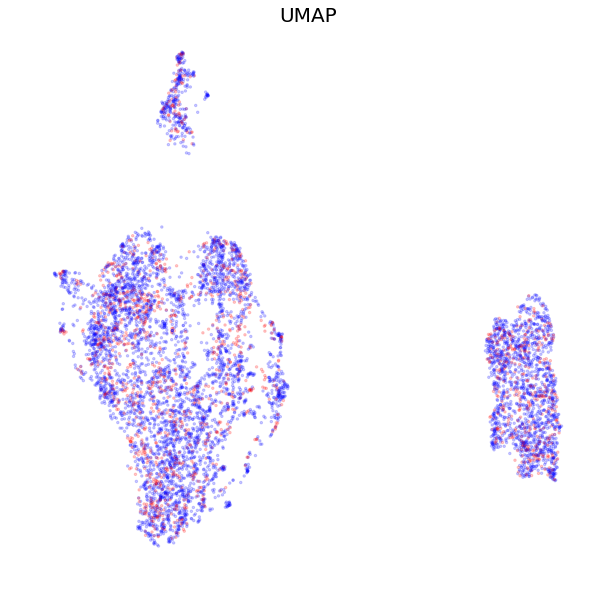

In [20]:
print("Total images: ", embedding.shape[0])
# https://github.com/lmcinnes/umap
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("UMAP",fontsize=20)


labels = test_df_retr["category"].tolist()
labels = ["r" if label=="tops" else "b" for label in labels]

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=6, alpha=0.2)
plt.axis("off")
plt.show()

Total images:  7344


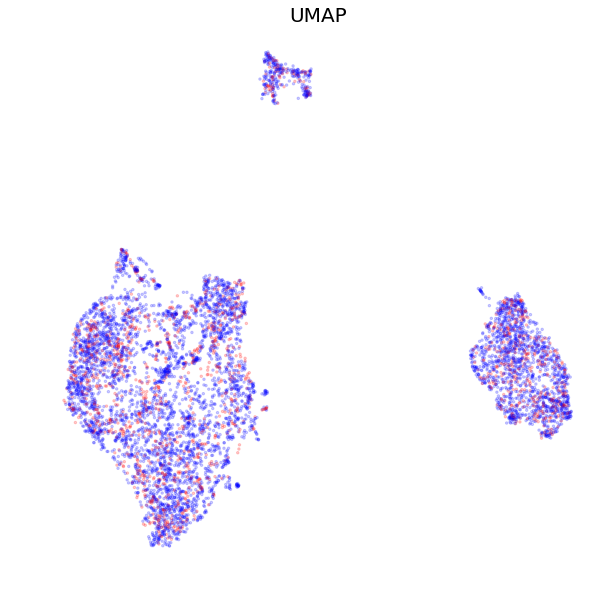

In [169]:
print("Total images: ", embedding.shape[0])
# https://github.com/lmcinnes/umap
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("UMAP",fontsize=20)


labels = test_df_retr["category"].tolist()
labels = ["r" if label=="tops" else "b" for label in labels]

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=6, alpha=0.2)
plt.axis("off")
plt.show()

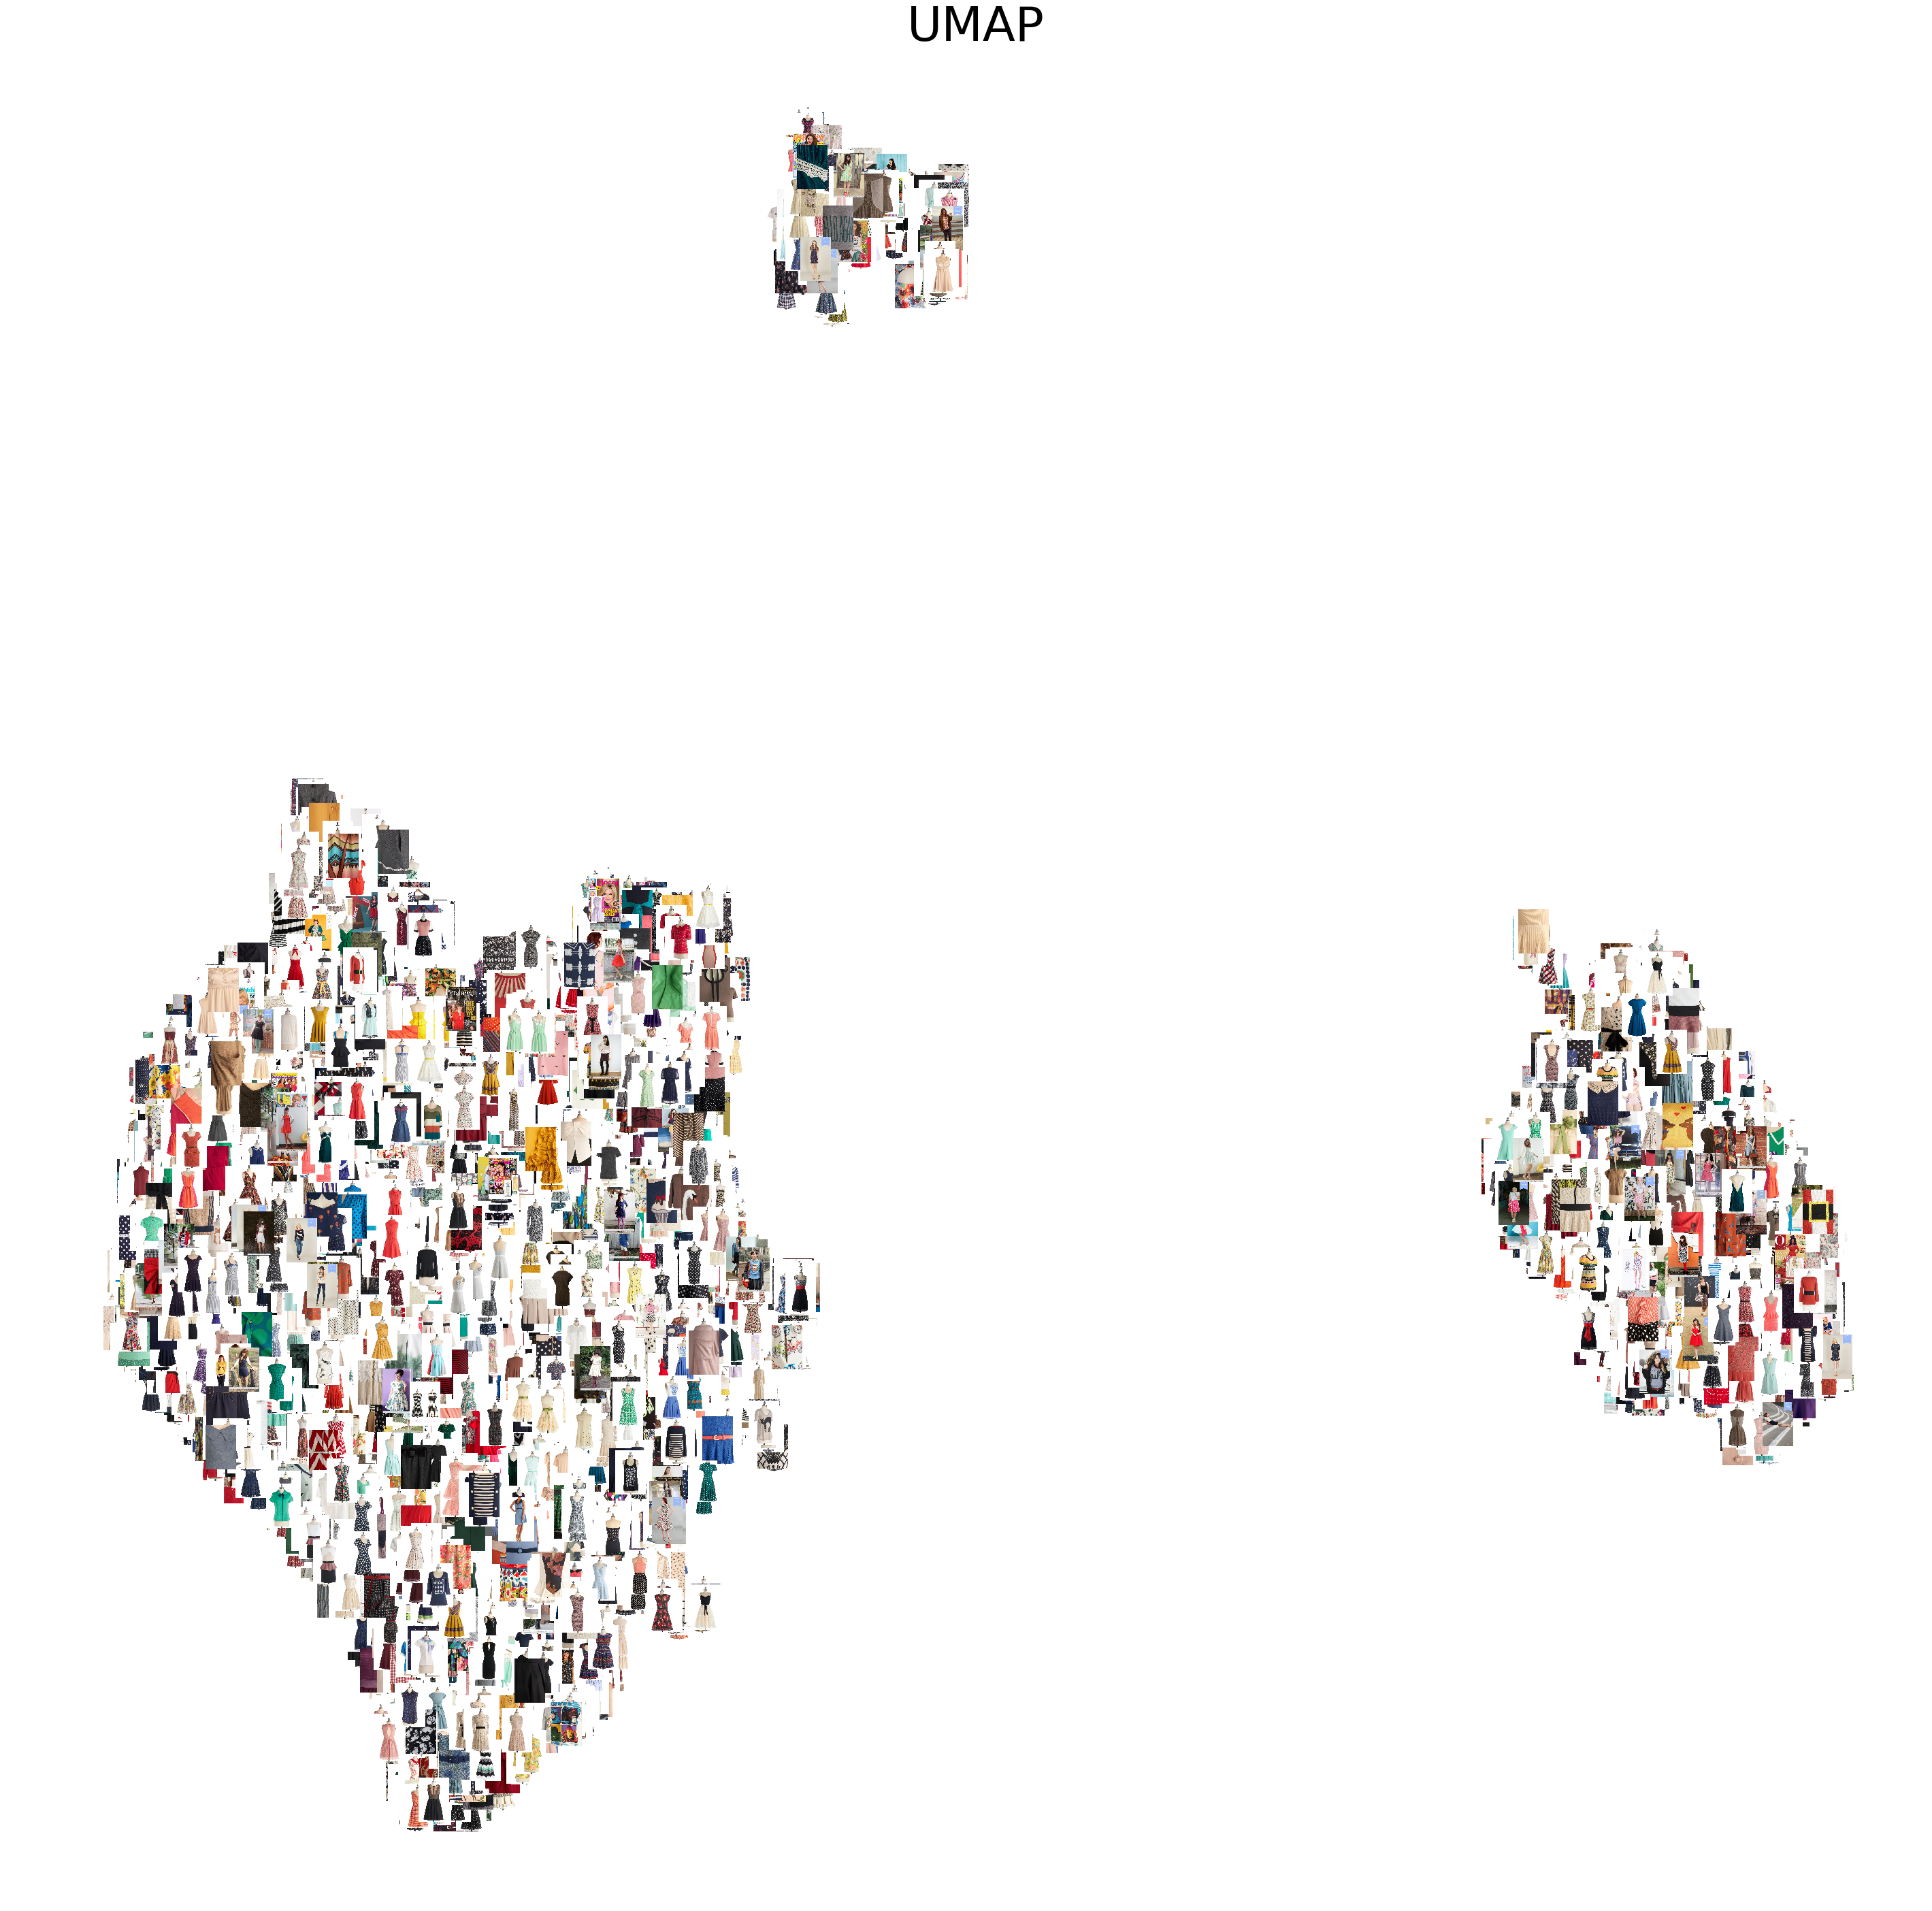

In [167]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_images(x, y, image_array, ax, zoom=0.1):
    im = OffsetImage(image_array, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    abox = AnnotationBbox(im, (x, y), xycoords="data", frameon=False)
    artists = ax.add_artist(abox)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

img_list = os.listdir(os.path.join(dataset_path, "validation", "retrieval"))
img_list = [os.path.join(dataset_path, "validation", "retrieval", img) for img in img_list]

fig, ax = plt.subplots(figsize=(50,50))
ax.set_title("UMAP", fontsize=70)

with tqdm(total=len(img_list)) as pbar:
    for img, xy in zip(img_list, embedding):
        img_array = plt.imread(img)
        x_ax =  xy[0]
        y_ax = xy[1]

        scatter_images(x_ax, y_ax, img_array, ax, zoom=0.15)
        pbar.update(1)
    plt.axis("off")
    #plt.savefig("tsne-dresses.png")
    plt.show()